In [1]:
import pandas as pd

In [2]:
recom_df = pd.read_pickle("data/recommendation_recipes.pkl")
recom_df

,name,description,cuisine,course,diet,prep_time,ingredients,instructions,cleaned_ingredients,categorized_prep_time,allergens,processed_name,processed_instructions,processed_description,allergen_type
0,Doddapatre Tambuli Recipe (Karpooravalli Thayi...,Doddapatre Tambuli Recipe is a popular healing...,Indian,Side Dish,Vegetarian,30.0,"4 cups Indian borage (Doddapatre) , cleaned an...","To begin making the Doddapatre Tambuli, first ...","[indian borage doddapatre, curd dahi yogurt,...",~30 min,[yogurt],Doddapatre Tambuli Recipe Karpooravalli Thayir...,begin make Doddapatre Tambuli first thoroughly...,Doddapatre Tambuli Recipe popular healing nour...,[Dairy]
1,Fish Tandoori Recipe,Have you ever tried out fish tandoori? Trust m...,North Indian,Appetizer,High Protein Non Vegetarian,80.0,"1 Fish , nicely washed with bones on (I used P...","To begin making the Fish Tandoori recipe, keep...","[fish, curd dahi yogurt, onion, green chilli...",~1 hour 30 min,[fish],Fish Tandoori Recipe,begin make fish Tandoori recipe keep head tail...,ever try fish tandoori trust equally delicious...,[Fish and Shellfish]
2,Arbi Shimla Mirch Sabzi Recipe – Colocasia Cap...,Arbi Shimla Mirch Sabzi Recipe is a variation ...,North Indian,Main Course,No Onion No Garlic (Sattvic),55.0,300 grams Colocasia root (Arbi) 1 Green Bell ...,To begin making the Arbi Shimla Mirch Sabzi Re...,"[colocasia root arbi, green bell pepper capsic...",~1 hour,[peanut],Arbi Shimla Mirch Sabzi Recipe Colocasia Capsi...,begin make Arbi Shimla Mirch Sabzi Recipe firs...,Arbi Shimla Mirch Sabzi Recipe variation aloo ...,"[Tree Nuts and Peanuts, Legumes and Seeds]"
3,Ambur Style Brinjal Curry Recipe,Brinjal Curry is prepared in different ways in...,Indian,Lunch,Vegetarian,20.0,5 Brinjal (Baingan / Eggplant) 1 Onion 2 Tom...,To begin making the Ambur Style Brinjal Curry ...,"[brinjal baingan eggplant, onion, ginger gar...",~30 min,"[sesame, mustard, peanut]",Ambur Style Brinjal Curry Recipe,begin make Ambur Style Brinjal Curry Recipe ad...,Brinjal Curry prepare different way different ...,"[Legumes and Seeds, Tree Nuts and Peanuts]"
4,Mavinakayi Menasinakai Curry Recipe - Raw Man...,Mangalorean Mavinakayi Menasinakai Curry Recip...,Mangalorean,Side Dish,Vegetarian,35.0,"1 cup Mango (Raw) , diced 2 tablespoons Jagge...",To begin making Mangalorean Mavinakayi Menasin...,"[mango, jaggery, turmeric powder, tamarind wat...",~45 min,[sesame],mavinakayi Menasinakai Curry Recipe Raw Mango ...,begin make Mangalorean Mavinakayi Menasinakai ...,Mangalorean Mavinakayi Menasinakai Curry Recip...,[Legumes and Seeds]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9491,Spinach Oats Vada Recipe,Spinach Oats Vada Recipe is a healthy twist to...,South Indian,Snack,Vegetarian,50.0,"Spinach Leaves (Palak), Chana dal (Bengal Gram...","To prepare Spinach Oats Vada Recipe, in a larg...","[spinach leave palak, chana dal bengal gram da...",~1 hour,unknown,Spinach Oats Vada Recipe,prepare Spinach Oats Vada Recipe large mixing ...,Spinach Oats Vada Recipe healthy twist otherwi...,Unknown
9492,Kerala Style Vettu Cake Recipe (Eggless Wholew...,Vettu cake is a famous tea shop snack in Tamil...,Kerala,Snack,Vegetarian,65.0,"Whole Wheat Flour, Sugar, Cooking soda, Butter...",To prepare Kerala Style Vettu Cake Recipe (Egg...,"[whole wheat flour, sugar, cook soda, butter s...",~1 hour 15 min,"[milk, wheat, egg, butter]",Kerala Style Vettu Cake Recipe eggless Wholewh...,prepare Kerala Style Vettu Cake Recipe eggless...,vettu cake famous tea shop snack Tamil Nadu Ke...,"[Dairy, Grains and Gluten, Eggs]"
9493,Amla/Nellikai Thogayal Recipe (Gooseberry Chut...,The Gooseberry (Amla/Nellikai) Chutney recipe ...,South Indian,Side Dish,Vegetarian,25.0,"Amla (Nellikai/ Gooseberry), Fresh coconut, Me...","To begin making the Amla Thogayal, we will fir...","[amla nellikai gooseberry, fresh coconut, meth...",~30 min,unknown,Amla Nellikai Thogayal Recipe Gooseberry Chutney,begin make Amla Thogayal first deseed goosebe

In [3]:
recom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    9496 non-null   object 
 1   description             9496 non-null   object 
 2   cuisine                 9488 non-null   object 
 3   course                  9462 non-null   object 
 4   diet                    9462 non-null   object 
 5   prep_time               9487 non-null   float64
 6   ingredients             9496 non-null   object 
 7   instructions            9496 non-null   object 
 8   cleaned_ingredients     9496 non-null   object 
 9   categorized_prep_time   9496 non-null   object 
 10  allergens               9496 non-null   object 
 11  processed_name          9496 non-null   object 
 12  processed_instructions  9496 non-null   object 
 13  processed_description   9496 non-null   object 
 14  allergen_type           9496 non-null   

In [4]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Convert each list in the 'cleaned_ingredient' column to a space-separated string to standardize the form of all precocessed colmuns. 
recom_df["processed_ingredients"] = recom_df['cleaned_ingredients'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Combine all processed columns into a single column for topic modeling
recom_df['combined_context'] = recom_df['processed_name'] + ' ' + recom_df['processed_ingredients'] + ' ' + recom_df['processed_description'] + ' ' + recom_df['processed_instructions']


tfidf_vectorizer = TfidfVectorizer()

tfidf_combined_matrix = tfidf_vectorizer.fit_transform(recom_df['combined_context'])


# Define number of topics (adjust based on experimentation)
n_topics = 9

nmf_model = NMF(n_components=n_topics, random_state=42)
topic_matrix = nmf_model.fit_transform(tfidf_combined_matrix) # Topic distribution for each recipe

# Add topic distributions to recom_df
for i in range(n_topics):
    recom_df[f'topic_{i}'] = topic_matrix[:, i]

def get_recommendations(dish_name, df, num_recommendations=5):
    # Find the index of the given dish name
    recipe_index = df[df['processed_name'].str.contains(dish_name, case=False, na=False)].index
    if not recipe_index.any():
        print("Dish not found.")
        return None
    
    recipe_index = recipe_index[0]  # Get the first match if there are multiple
    
    # Calculate cosine similarity for the topics
    cosine_similarities = cosine_similarity(topic_matrix )
    similar_indices = cosine_similarities[recipe_index].argsort()[-num_recommendations-1:-1][::-1]
    
    # Get the recommended recipes
    recommended_recipes = df.iloc[similar_indices]
    return recommended_recipes[['name', 'cuisine', 'course', 'diet', 'categorized_prep_time', 'allergen_type']]

In [5]:
recom_df['combined_context']

0       Doddapatre Tambuli Recipe Karpooravalli Thayir...
1       Fish Tandoori Recipe fish curd dahi   yogurt o...
2       Arbi Shimla Mirch Sabzi Recipe Colocasia Capsi...
3       Ambur Style Brinjal Curry Recipe brinjal baing...
4       mavinakayi Menasinakai Curry Recipe Raw Mango ...
                              ...                        
9491    Spinach Oats Vada Recipe spinach leave palak c...
9492    Kerala Style Vettu Cake Recipe eggless Wholewh...
9493    Amla Nellikai Thogayal Recipe Gooseberry Chutn...
9494    Kanchakalar Khosha Bata Traditional Bengali Ra...
9495    Tomato Onion Chutney Recipe Coconut Mint onion...
Name: combined_context, Length: 9496, dtype: object

In [6]:
recom_df['processed_name']

0       Doddapatre Tambuli Recipe Karpooravalli Thayir...
1                                    Fish Tandoori Recipe
2       Arbi Shimla Mirch Sabzi Recipe Colocasia Capsi...
3                        Ambur Style Brinjal Curry Recipe
4       mavinakayi Menasinakai Curry Recipe Raw Mango ...
                              ...                        
9491                             Spinach Oats Vada Recipe
9492    Kerala Style Vettu Cake Recipe eggless Wholewh...
9493     Amla Nellikai Thogayal Recipe Gooseberry Chutney
9494    Kanchakalar Khosha Bata Traditional Bengali Ra...
9495             Tomato Onion Chutney Recipe Coconut Mint
Name: processed_name, Length: 9496, dtype: object

In [7]:
recom_df["processed_ingredients"] 

0       indian borage doddapatre curd dahi   yogurt cu...
1       fish curd dahi   yogurt onion green chilli tan...
2       colocasia root arbi green bell pepper capsicum...
3       brinjal baingan   eggplant onion ginger garlic...
4       mango jaggery turmeric powder tamarind water s...
                              ...                        
9491    spinach leave palak chana dal bengal gram dal ...
9492    whole wheat flour sugar cook soda butter salt ...
9493    amla nellikai gooseberry fresh coconut methi s...
9494    raw banana garlic green chilli salt mustard oi...
9495    onion tomatoe green chilli mint leave pudina f...
Name: processed_ingredients, Length: 9496, dtype: object

In [8]:
# Define a function to filter based on user preferences
def filter_recipes(df, cuisine=None, course=None, diet=None, prep_time=None, allergen_type=None):
    filtered_df = df
    if cuisine:
        filtered_df = filtered_df[filtered_df['cuisine'] == cuisine]
    if course:
        filtered_df = filtered_df[filtered_df['course'] == course]
    if diet:
        filtered_df = filtered_df[filtered_df['diet'] == diet]
    if prep_time:
        filtered_df = filtered_df[filtered_df['categorized_prep_time'] == prep_time]
    if allergen_type:
        # Exclude recipes with allergens in user preference
        filtered_df = filtered_df[~filtered_df['allergen_type'].apply(lambda x: bool(set(x) & set(allergen_type)))]
    return filtered_df

##apply(lambda x: "Grains and Gluten" in x)
# Example 
recommended_recipes = get_recommendations("brinjal", recom_df)  
if recommended_recipes is not None:
    filtered_recommendations = filter_recipes(recommended_recipes)
    print(filtered_recommendations)

                                                   name       cuisine  \
4004                   Ambur Style Brinjal Curry Recipe        Indian   
3681  Chettinad Kathirikai Chops Recipe - Brinjal Cu...     Chettinad   
7997        Tamatar Gosht Recipe-Mutton In Tomato Curry  North Indian   
1836    Attirachi Kuzhambu Recipe - Spicy Mutton Gravy   South Indian   
2283        Tamatar Gosht Recipe-Mutton In Tomato Curry  North Indian   

           course            diet categorized_prep_time  \
4004        Lunch      Vegetarian               ~30 min   
3681  Main Course      Vegetarian               ~45 min   
7997       Dinner  Non Vegeterian               ~1 hour   
1836        Lunch  Non Vegeterian               ~45 min   
2283       Dinner  Non Vegeterian               ~1 hour   

                                   allergen_type  
4004  [Legumes and Seeds, Tree Nuts and Peanuts]  
3681  [Legumes and Seeds, Tree Nuts and Peanuts]  
7997                                     Unknown  
18

In [9]:
recom_df.iloc[3608]

name                      Jeera Rice Recipe | Jeera Pulao | Cumin Flavou...
description               The Jeera Rice (Pulao) Recipe is simple rice r...
cuisine                                                              Indian
course                                                                Lunch
diet                                                             Vegetarian
prep_time                                                              30.0
ingredients               Seeraga (Jeeraga) Samba rice, Cumin seeds (Jee...
instructions              To begin making the\xa0Jeera Rice Recipe, firs...
cleaned_ingredients       [seeraga jeeraga samba rice, cumin seed jeera,...
categorized_prep_time                                               ~30 min
allergens                                                           unknown
processed_name            Jeera Rice Recipe Jeera Pulao Cumin Flavoured ...
processed_instructions    begin make Rice Recipe first rinse rice well w...
processed_de

In [10]:
#pip install gensim

Num Topics: 2, Coherence Score: 0.573655374295369
Num Topics: 3, Coherence Score: 0.568506923559221
Num Topics: 4, Coherence Score: 0.5454392688009377
Num Topics: 5, Coherence Score: 0.5929184070563343
Num Topics: 6, Coherence Score: 0.6276393816596851
Num Topics: 7, Coherence Score: 0.6414563265983393
Num Topics: 8, Coherence Score: 0.6521364294171816
Num Topics: 9, Coherence Score: 0.6562001777799372


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


Num Topics: 10, Coherence Score: nan


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Num Topics: 11, Coherence Score: nan


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

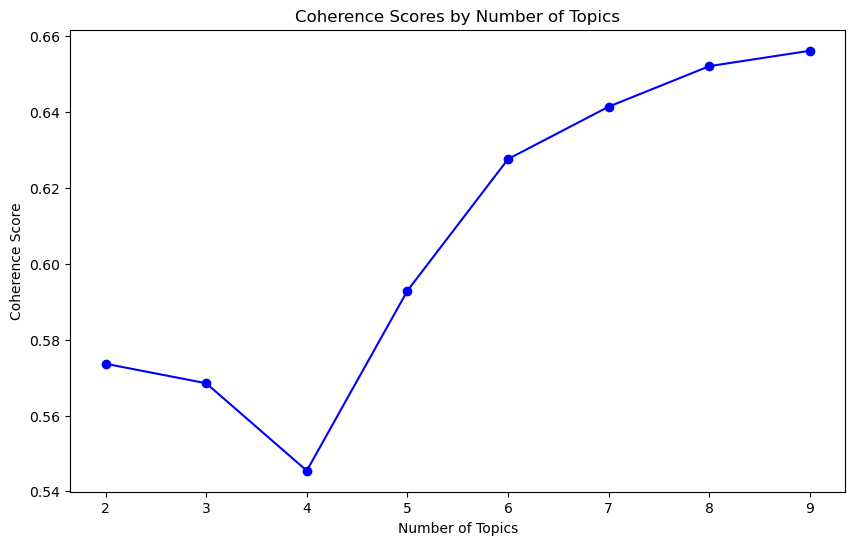

In [11]:
from gensim.models import CoherenceModel
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt

def compute_coherence_scores(texts, vectorizer, num_topics_range):
    coherence_scores = []
    tfidf_matrix = vectorizer.fit_transform(texts)
    for num_topics in num_topics_range:
        nmf_model = NMF(n_components=num_topics, random_state=42)
        topic_matrix = nmf_model.fit_transform(tfidf_matrix)
        
        # Get topics and compute coherence

        topics = []
        feature_names = vectorizer.get_feature_names_out()
        for topic_idx, topic in enumerate(nmf_model.components_):
            topic_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
            topics.append(topic_words)

        # Prepare data for coherence model
        dictionary = Dictionary([topic_words for topic_words in topics])
        corpus = [dictionary.doc2bow(text.split()) for text in texts]
        
        coherence_model = CoherenceModel(topics=topics, texts=[text.split() for text in texts], dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        print(f"Num Topics: {num_topics}, Coherence Score: {coherence_score}")
    
        plt.figure(figsize=(10, 6))
    plt.plot(num_topics_range, coherence_scores, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores by Number of Topics")
    plt.show()
    
    return coherence_scores

texts = recom_df['combined_context']  
vectorizer = TfidfVectorizer()
num_topics_range = range(2, 12,1)

coherence_scores = compute_coherence_scores(texts, vectorizer, num_topics_range)